#### Assignmet 1 - Computer Vision, Digit Classification

#### Imports

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [81]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

#### Import MNIST dataset, creating training and test sets

In [82]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

#### Exploratory Data Analysis

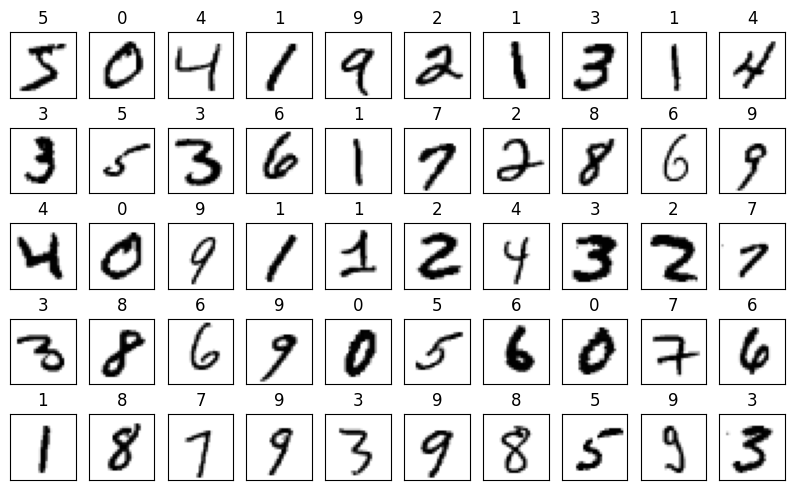

In [96]:
# First 50 images
fig = plt.figure(figsize = (10, 6))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

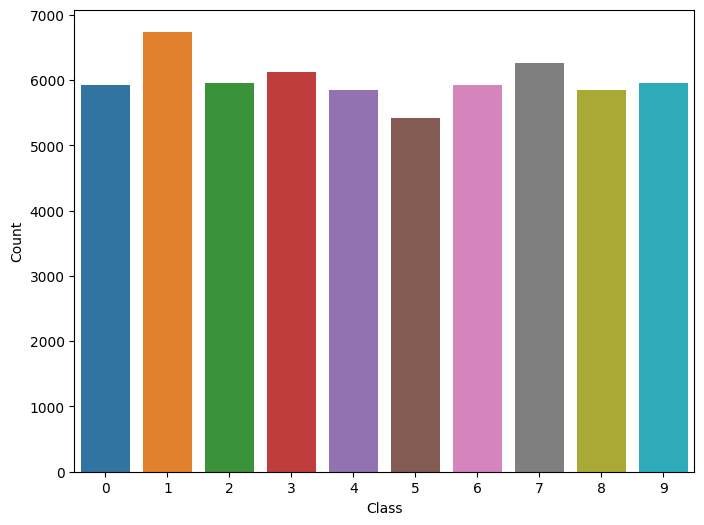

In [97]:
# Frequency chart of classificatinos
plt.figure(figsize = (8 ,6))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [85]:
# Example of sample input
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2027]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  77 254 220   0   0   0   0   0   0   0   4  60  48 118  25   0   0   0   0   0   0   0   0]
 [  0   0   0   0  37 218 253 250 234 234 234 234 234 234 234 234 244 242 253 18

#### Data pre-processing

In [86]:
# Apply one hot encoding to the labels, creating binary variables for 0-9 indicating classification

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:4,]))

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)
First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [87]:
# Reshape the 28x28 inputs to 1x784

# Reshape the sets:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


In [88]:
# Normalize the inputs by dividing values by 255 (max greyscale value)

x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

#### Experiment Set 1

#### Experiment 1 - MLP with one hidden layer (1)

In [89]:
# Experiment 2

# Step 1 - Create model architecture using the Sequential class
model_one = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_one.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy','Precision','ce','Recall','F1Score','AUC'])

# Step 3 - Traing the model, saving the best model
training_one = history = model_one.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_one.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_one = tf.keras.models.load_model("model_one.h5")

# Step 4 - Predict the test set
preds_one = model_one.predict(x_test_norm)
preds_one = np.argmax(preds_one, axis=1)

Epoch 1/200
1500/1500 [==============================] - 2s 683us/step - loss: 1.9928 - accuracy: 0.2000 - precision: 0.9688 - ce: 1.9874 - recall: 0.0136 - f1_score: 0.1295 - auc: 0.7454 - val_loss: 1.8820 - val_accuracy: 0.2245 - val_precision: 0.9701 - val_ce: 1.8737 - val_recall: 0.0460 - val_f1_score: 0.1213 - val_auc: 0.7724
Epoch 2/200
 324/1500 [=====>........................] - ETA: 0s - loss: 1.8846 - accuracy: 0.2188 - precision: 0.9538 - ce: 1.8762 - recall: 0.0438 - f1_score: 0.1491 - auc: 0.7718

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 1s 569us/step - loss: 1.8420 - accuracy: 0.2503 - precision: 0.9287 - ce: 1.8330 - recall: 0.0483 - f1_score: 0.1884 - auc: 0.7854 - val_loss: 1.7951 - val_accuracy: 0.2968 - val_precision: 0.9330 - val_ce: 1.7857 - val_recall: 0.0568 - val_f1_score: 0.2125 - val_auc: 0.8011
Epoch 3/200
1500/1500 [==============================] - 1s 555us/step - loss: 1.7690 - accuracy: 0.2956 - precision: 0.8841 - ce: 1.7592 - recall: 0.0561 - f1_score: 0.2320 - auc: 0.8097 - val_loss: 1.7310 - val_accuracy: 0.3262 - val_precision: 0.8703 - val_ce: 1.7209 - val_recall: 0.0671 - val_f1_score: 0.2163 - val_auc: 0.8192
Epoch 4/200
1500/1500 [==============================] - 1s 592us/step - loss: 1.7250 - accuracy: 0.3144 - precision: 0.8514 - ce: 1.7147 - recall: 0.0599 - f1_score: 0.2593 - auc: 0.8205 - val_loss: 1.6945 - val_accuracy: 0.3328 - val_precision: 0.8662 - val_ce: 1.6842 - val_recall: 0.0658 - val_f1_score: 0.2578 - val_auc: 0.8290
Epoch 5/200
1

In [90]:
training_one_df = pd.DataFrame(training_one.history)
training_one_df

,loss,accuracy,precision,ce,recall,f1_score,auc,val_loss,val_accuracy,val_precision,val_ce,val_recall,val_f1_score,val_auc
0,1.992757,0.199958,0.968843,1.987357,0.013604,"[0.0037468777, 0.24077317, 0.25781482, 0.09848...",0.745357,1.882002,0.224500,0.970123,1.873735,0.046000,"[0.29322928, 0.06595864, 0.006498781, 0.084582...",0.772423
1,1.842035,0.250292,0.928743,1.833045,0.048333,"[0.25284803, 0.24453235, 0.016253868, 0.061221...",0.785392,1.795118,0.296833,0.932969,1.785650,0.056833,"[0.0, 0.42698795, 0.008156607, 0.044088174, 0....",0.801086
2,1.769001,0.295604,0.884072,1.759164,0.056083,"[0.25907353, 0.39336064, 0.023936167, 0.075175...",0.809718,1.731026,0.326167,0.870270,1.720874,0.067083,"[0.33405203, 0.5555556, 0.028294861, 0.1285866...",0.819208
3,1.725031,0.314438,0.851435,1.714662,0.059937,"[0.3050449, 0.47500202, 0.03527273, 0.10714286...",0.820502,1.694541,0.332833,0.866228,1.684157,0.065833,"[0.3555762, 0.50344396, 0.027900148, 0.1831757...",0.828988
4,1.695854,0.333167,0.828909,1.685423,0.059854,"[0.3540953, 0.5053348, 0.051334005, 0.19533016...",0.830830,1.666402,0.347333,0.846154,1.656166,0.062333,"[0.3812191, 0.53083986, 0.06491121, 0.22835751...",0.840265
5,1.669680,0.342271,0.804933,1.659324,0.059146,"[0.39783373, 0.52025455, 0.08740051, 0.2853508...",0.841284,1.643325,0.360917,0.821918,1.633292,0.065000,"[0.4442626, 0.5470654, 0.10333334, 0.2760736, ...",0.848508
6,1.646295,0.354667,0.783982,1.635985,0.057917,"[0.41448984, 0.54439205, 0.115884386, 0.326062...",0.848749,1.619622,0.354000,0.781431,1.609184,0.067333,"[0.4569733, 0.5548163, 0.13089803, 0.34194958,...",0.855335
7,1.627285,0.363187,0.766088,1.616739,0.057042,"[0.44325954, 0.5511009, 0.145, 0.34284806, 0.0...",0.854129,1.600815,0.369583,0.799141,1.590245,0.062000,"[0.0, 0.56223065, 0.13730195, 0.3142448, 0.0, ...",0.859375
8,1.611747,0.370562,0.754717,1.601025,0.056667,"[0.3858261, 0.56106824, 0.17025861, 0.33886215...",0.857837,1.588883,0.371583,0.763343,1.577884,0.063167,"[0.006546645, 0.55439496, 0.15218459, 0.348300...",0.862017
9,1.600025,0.376104,0.748134,1.589024,0.056375,"[0.3933618, 0.5692053, 0.18314934, 0.33602107,...",0.860362,1.590755,0.369000,0.798876,1.579466,0.059250,"[0.0, 0.56300265, 0.13202247, 0.3511886, 0.0, ...",0.859668


In [91]:
print_validation_report(y_test,preds_one)

Classification Report
              precision    recall  f1-score   support

           0       0.19      0.02      0.04       980
           1       0.48      0.82      0.61      1135
           2       0.21      0.19      0.20      1032
           3       0.28      0.43      0.34      1010
           4       0.43      0.23      0.30       982
           5       0.24      0.04      0.06       892
           6       0.34      0.87      0.49       958
           7       0.61      0.67      0.64      1028
           8       0.00      0.00      0.00       974
           9       0.37      0.46      0.41      1009

    accuracy                           0.38     10000
   macro avg       0.32      0.37      0.31     10000
weighted avg       0.32      0.38      0.32     10000

Accuracy Score: 0.382
Root Mean Square Error: 3.3292041090927422


/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

/var/folders/hb/_tr1b6d918vdtcwmymd4p0v80000gn/T/ipykernel_3987/3451112158.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


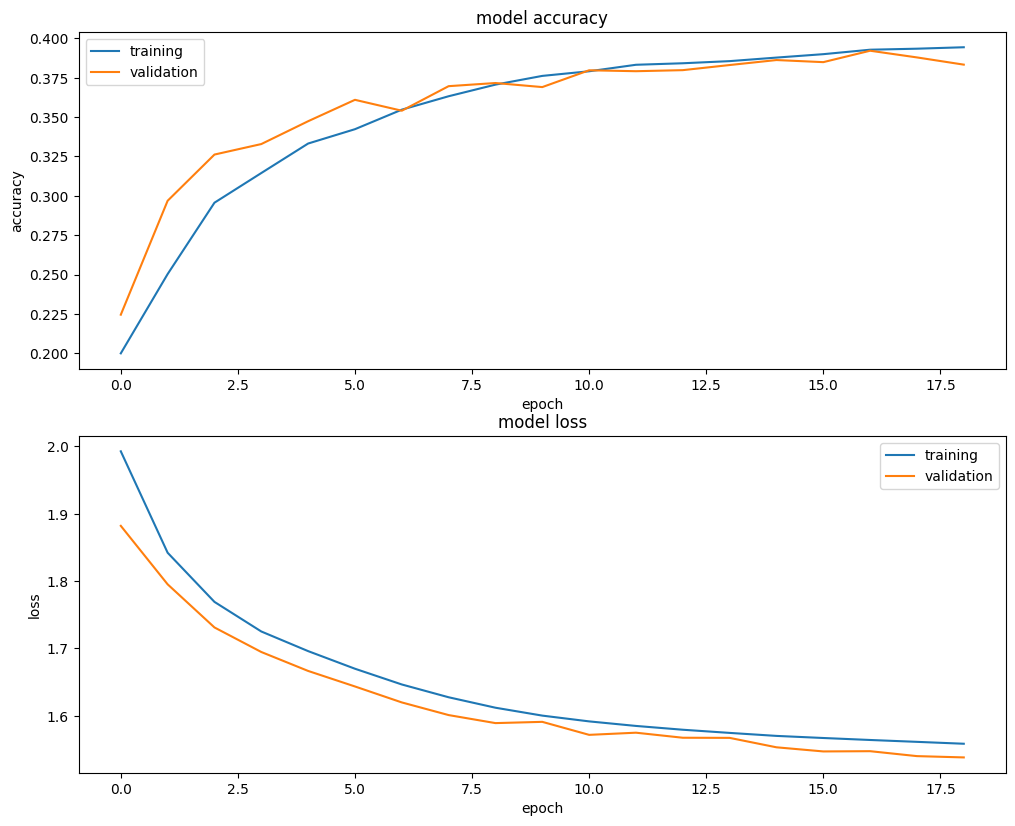

In [103]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,8))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

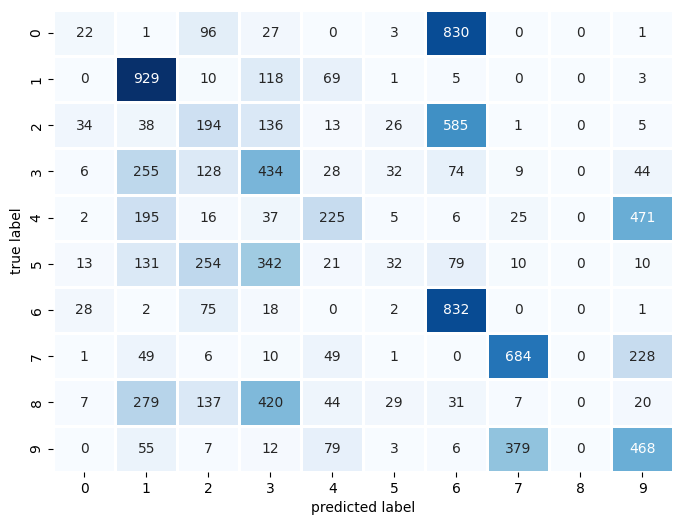

In [93]:
plot_confusion_matrix(y_test,preds_one)

In [ ]:
# Analyzing model performance
    # Training epoch summary statistics - epoch count, stopping number, accuracy, loss, validation accuracy, validation loss (accessible by at least Model.history)
    # Plot of training curve
    # Validation report (precision, recall, f1 score, support)
    # Confusion matrix

#### Experiment 2 - MLP with one hidden layer (2)

In [11]:
# Experiment 2

# Step 1 - Create model architecture using the Sequential class
model_two = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_two.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_two = history = model_two.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_two.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_two = tf.keras.models.load_model("model_two.h5")

# Step 4 - Predict the test set
preds_two = model_two.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 1s 516us/step - loss: 1.7049 - accuracy: 0.3268 - val_loss: 1.4877 - val_accuracy: 0.4069
Epoch 2/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.3758 - accuracy: 0.4911 - val_loss: 1.2561 - val_accuracy: 0.5689
Epoch 3/200
1500/1500 [==============================] - 1s 472us/step - loss: 1.2261 - accuracy: 0.5727 - val_loss: 1.1666 - val_accuracy: 0.6028
Epoch 4/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.1691 - accuracy: 0.5961 - val_loss: 1.1297 - val_accuracy: 0.6183
Epoch 5/200
1500/1500 [==============================] - 1s 463us/step - loss: 1.1366 - accuracy: 0.6143 - val_loss: 1.1002 - val_accuracy: 0.6248
Epoch 6/200
1500/1500 [==============================] - 1s 465us/step - loss: 1.1156 - accuracy: 0.6220 - val_loss: 1.0880 - val_accuracy: 0.6308
Epoch 7/200
1500/1500 [==============================] - 1s 465us/step - loss: 1.1023 - accuracy: 0.6261 - val_loss: 1

#### Experiment 3 - MLP with one hidden layer (10)

In [12]:
# Experiment 3

# Step 1 - Create model architecture using the Sequential class
model_three = Sequential([
    Dense(input_shape=[784], units=10, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_three.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_three = history = model_three.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_three.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_three = tf.keras.models.load_model("model_three.h5")

# Step 4 - Predict the test set
preds_three = model_three.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 1s 534us/step - loss: 0.5685 - accuracy: 0.8546 - val_loss: 0.3609 - val_accuracy: 0.9133
Epoch 2/200
1500/1500 [==============================] - 1s 519us/step - loss: 0.3694 - accuracy: 0.9077 - val_loss: 0.3423 - val_accuracy: 0.9166
Epoch 3/200
1500/1500 [==============================] - 1s 495us/step - loss: 0.3498 - accuracy: 0.9131 - val_loss: 0.3235 - val_accuracy: 0.9218
Epoch 4/200
1500/1500 [==============================] - 1s 496us/step - loss: 0.3367 - accuracy: 0.9166 - val_loss: 0.3231 - val_accuracy: 0.9220
Epoch 5/200
1500/1500 [==============================] - 1s 481us/step - loss: 0.3259 - accuracy: 0.9189 - val_loss: 0.3139 - val_accuracy: 0.9225
Epoch 6/200
1500/1500 [==============================] - 1s 475us/step - loss: 0.3167 - accuracy: 0.9210 - val_loss: 0.3021 - val_accuracy: 0.9277
Epoch 7/200
1500/1500 [==============================] - 1s 478us/step - loss: 0.3084 - accuracy: 0.9227 - val_loss: 0

#### Experiment 4 - MLP with one hidden-layer (128)

In [13]:
# Experiment 4

# Step 1 - Create model architecture using the Sequential class
model_four = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_four.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_four = model_four.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_four.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_four = tf.keras.models.load_model("model_four.h5")

# Step 4 - Predict the test set
preds_four = model_four.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3965 - accuracy: 0.9148 - val_loss: 0.2588 - val_accuracy: 0.9481
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2390 - accuracy: 0.9515 - val_loss: 0.2031 - val_accuracy: 0.9618
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2000 - accuracy: 0.9598 - val_loss: 0.1857 - val_accuracy: 0.9626
Epoch 4/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1821 - accuracy: 0.9634 - val_loss: 0.1809 - val_accuracy: 0.9616
Epoch 5/200
313/313 [==============================] - 0s 394us/step


#### Experiment Set 1 Results

#### Experiment Set 2

#### Experiment 5 - MLP with one hidden layer (128), adam optimizer

In [14]:
# Experiment 5

# Step 1 - Create model architecture using the Sequential class
model_five = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_five.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_five = model_five.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_five.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_five = tf.keras.models.load_model("model_five.h5")

# Step 4 - Predict the test set
preds_five = model_five.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 999us/step - loss: 0.4135 - accuracy: 0.9148 - val_loss: 0.2719 - val_accuracy: 0.9470
Epoch 2/200
1500/1500 [==============================] - 1s 992us/step - loss: 0.2489 - accuracy: 0.9531 - val_loss: 0.2251 - val_accuracy: 0.9599
Epoch 3/200
1500/1500 [==============================] - 1s 866us/step - loss: 0.2163 - accuracy: 0.9609 - val_loss: 0.1990 - val_accuracy: 0.9679
Epoch 4/200
1500/1500 [==============================] - 1s 898us/step - loss: 0.1980 - accuracy: 0.9648 - val_loss: 0.1991 - val_accuracy: 0.9646
Epoch 5/200
313/313 [==============================] - 0s 399us/step


#### Experiment 6 - MLP with two hidden layers (128, 64), rmsprop optimizer

In [15]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_six = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_six.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_six = model_six.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_six.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_six = tf.keras.models.load_model("model_six.h5")

# Step 4 - Predict the test set
preds_six = model_six.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4403 - accuracy: 0.9178 - val_loss: 0.2893 - val_accuracy: 0.9536
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2584 - accuracy: 0.9568 - val_loss: 0.2171 - val_accuracy: 0.9659
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2188 - accuracy: 0.9627 - val_loss: 0.2107 - val_accuracy: 0.9621
Epoch 4/200
313/313 [==============================] - 0s 399us/step


#### Experiment 7 - MLP with two hidden layers (128, 64), adam optimizer

In [16]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_seven = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_seven.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_seven = model_seven.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_seven.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_seven = tf.keras.models.load_model("model_seven.h5")

# Step 4 - Predict the test set
preds_seven = model_seven.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4609 - accuracy: 0.9158 - val_loss: 0.3181 - val_accuracy: 0.9502
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2832 - accuracy: 0.9563 - val_loss: 0.2526 - val_accuracy: 0.9614
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2425 - accuracy: 0.9627 - val_loss: 0.2386 - val_accuracy: 0.9610
Epoch 4/200
1500/1500 [==============================] - 1s 976us/step - loss: 0.2210 - accuracy: 0.9667 - val_loss: 0.2197 - val_accuracy: 0.9665
Epoch 5/200
1500/1500 [==============================] - 1s 968us/step - loss: 0.2052 - accuracy: 0.9699 - val_loss: 0.2062 - val_accuracy: 0.9681
Epoch 6/200
1500/1500 [==============================] - 1s 979us/step - loss: 0.1965 - accuracy: 0.9709 - val_loss: 0.2085 - val_accuracy: 0.9659
Epoch 7/200
313/313 [==============================] - 0s 409us/step


#### Experiment 8 - MLP with three hidden layers (128, 64, 32), adam optimizer

In [17]:
# Experiment 6

# Step 1 - Create model architecture using the Sequential class
model_eight = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[128],units=64,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(input_shape=[64],units=32,activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

# Step 2 - Compile the model
model_eight.compile(optimizer='adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Step 3 - Traing the model, saving the best model
training_eight = model_eight.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("model_eight.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

# Step 3a - Load the best model
model_eight = tf.keras.models.load_model("model_eight.h5")

# Step 4 - Predict the test set
preds_eight = model_eight.predict(x_test_norm)

Epoch 1/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5069 - accuracy: 0.9104 - val_loss: 0.3351 - val_accuracy: 0.9529
Epoch 2/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3114 - accuracy: 0.9551 - val_loss: 0.2822 - val_accuracy: 0.9638
Epoch 3/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2631 - accuracy: 0.9641 - val_loss: 0.2589 - val_accuracy: 0.9635
Epoch 4/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2437 - accuracy: 0.9660 - val_loss: 0.2380 - val_accuracy: 0.9673
Epoch 5/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2249 - accuracy: 0.9703 - val_loss: 0.2397 - val_accuracy: 0.9663
Epoch 6/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2143 - accuracy: 0.9711 - val_loss: 0.2185 - val_accuracy: 0.9709
Epoch 7/200
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2077 - accuracy: 0.9714 - val_loss: 0.2121 - val_ac

#### Experiment Set 2 Results

#### Experiment Set 3 - Feature Engineering

#### Experiment 9 - Feature Engineering via Pincipal Component Analysis (154 features)

#### Experiment 10 - Feature Engineering via Random Forest (70 features)

#### Experiment Set 3 Results